# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
Updating files:  33% (1902/5717)
Updating files:  34% (1944/5717)
Updating files:  35% (2001/5717)
Updating files:  36% (2059/5717)
Updating files:  37% (2116/5717)
Updating files:  38% (2173/5717)
Updating files:  39% (2230/5717)
Updating files:  40% (2287/5717)
Updating files:  41% (2344/5717)
Updating files:  42% (2402/5717)
Updating files:  43% (2459/5717)
Updating files:  44% (2516/5717)
Updating files:  45% (2573/5717)
Updating files:  46% (2630/5717)
Updating files:  47% (2687/5717)
Updating files:  48% (2745/5717)
Updating files:  49% (2802/5717)
Updating files:  50% (2859/5717)
Updating files:  51% (2916/5717)
Updating files:  52% (2973/5717)
Updating files:  53% (3031/5717)
Updating files:  54% (3088/5717)
Updating files:  55% (3145/5717)
Updating files:  56% (3202/5717)
Updating files:  57% (3259/5717)
Updating files:  58% (3316/5717)
Updating files:  59% (3374/5717)
Updating files:  60% (3431/5717)
Updating files:  61% (3488/5717)
Updat

In [1]:
import torch
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F


In [144]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [145]:
def train_one_epoch(epoch_index, model, dataloader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader)
    print(f'Epoch {epoch_index+1}, Loss: {train_loss}')
    return train_loss

In [146]:
def get_validation_acc(epoch_index, model, dataloader):
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    print(f'Epoch {epoch_index+1} Validation Accuracy: {val_acc}%')
    return val_acc

In [154]:
def train_and_validation(model, number_of_epochs, optimizer, loss_fn, train_dataloader, val_dataloader, scheduler=None):
    # Training loop with combined plotting
    n_epochs = number_of_epochs
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    
    for epoch_index in range(n_epochs):
        train_loss = train_one_epoch(epoch_index, model, train_dataloader, optimizer, loss_fn)
        val_accuracy = get_validation_acc(epoch_index, model, val_dataloader)
        val_acc.append(val_accuracy)
        train_losses.append(train_loss)
        
        if scheduler:
            # Step the scheduler
            scheduler.step(val_accuracy)
            
    return train_acc, val_acc, train_losses, val_losses

In [155]:
def report_metrics(n_epochs, train_acc, val_acc):
    print(f"Best Validation Score: {max(val_acc)}")
    # Plotting the accuracies and losses
    plt.figure(figsize=(14, 7))
    
    # Plot accuracy
    plt.plot(range(n_epochs), train_acc, label='Training Accuracy')
    plt.plot(range(n_epochs), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()


In [156]:
transform = transform = T.Compose([
    T.Resize((128, 128)),
    # T.RandomHorizontalFlip(),
    # T.RandomRotation(10),
    # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    ])

# Create Datasets
train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [157]:
class SimpleCNN_6conv_128x128(nn.Module):
    def __init__(self, num_classes=43):
        super(SimpleCNN_6conv_128x128, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(in_features=128 * 2 * 2, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x
    
class SimpleCNN_6conv_224x224(nn.Module):
    def __init__(self, num_classes=43):
        super(SimpleCNN_6conv_224x224, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

class CustomCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.40)

        self.fc1 = nn.Linear(32 * 8 * 8 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x


In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN_6conv_128x128().to(device)
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 96, 16, 16]          55,392
         MaxPool2d-8             [-1, 96, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         110,720
        MaxPool2d-10            [-1, 128, 4, 4]               0
           Conv2d-11            [-1, 128, 4, 4]         147,584
        MaxPool2d-12            [-1, 128, 2, 2]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                  [

In [159]:
# Optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.8, patience=3, verbose=True)

In [ ]:
train_acc, val_acc, train_losses, val_losses = train_and_validation(model, 40, optimizer, loss_fn, train_dataloader, val_dataloader, scheduler)

Epoch 1, Loss: 3.598099975700838
Epoch 0 Validation Accuracy: 9.797297297297296%
Epoch 2, Loss: 3.4788262097232314
Epoch 1 Validation Accuracy: 11.486486486486486%
Epoch 3, Loss: 3.4389749636133033
Epoch 2 Validation Accuracy: 10.135135135135135%
Epoch 4, Loss: 3.390974900808679
Epoch 3 Validation Accuracy: 12.5%
Epoch 5, Loss: 3.1908907717969046
Epoch 4 Validation Accuracy: 14.18918918918919%
Epoch 6, Loss: 2.997129382857357
Epoch 5 Validation Accuracy: 16.554054054054053%
Epoch 7, Loss: 2.918528872800161
Epoch 6 Validation Accuracy: 13.513513513513514%
Epoch 8, Loss: 2.823962349489511
Epoch 7 Validation Accuracy: 16.216216216216218%
Epoch 9, Loss: 2.6998530209782614
Epoch 8 Validation Accuracy: 17.905405405405407%
Epoch 10, Loss: 2.562617138207677
Epoch 9 Validation Accuracy: 19.93243243243243%
Epoch 11, Loss: 2.499586820602417
Epoch 10 Validation Accuracy: 23.31081081081081%
Epoch 12, Loss: 2.395832810057215
Epoch 11 Validation Accuracy: 22.635135135135137%
Epoch 13, Loss: 2.3570974

Best Validation Score: 45.27027027027027


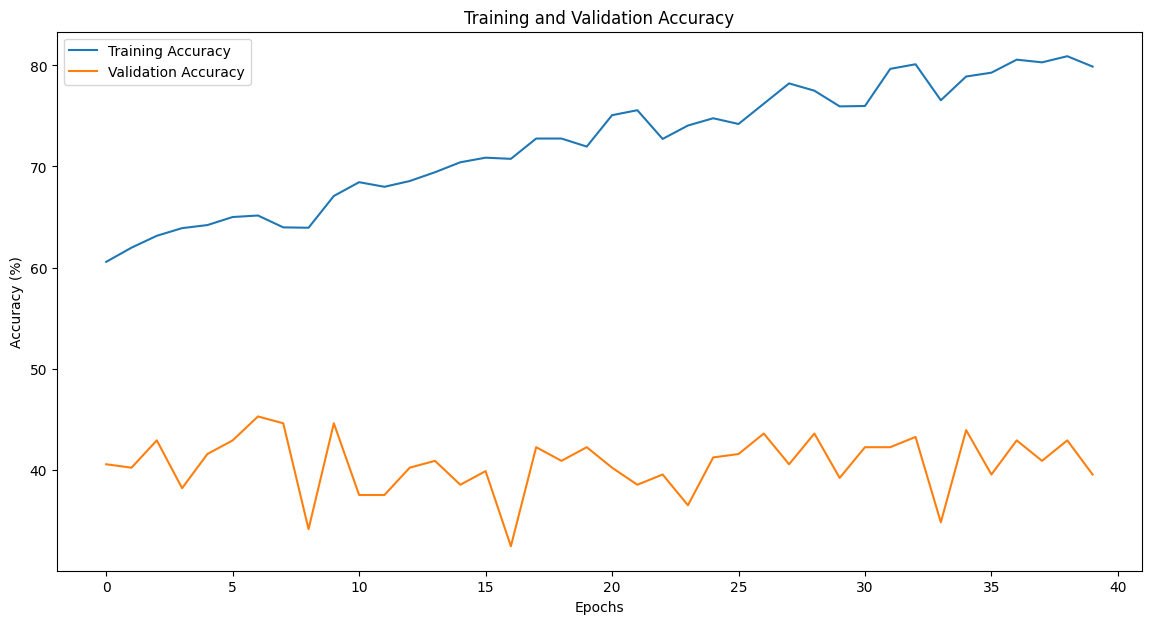

In [79]:
report_metrics(40, train_acc, val_acc)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [92]:

# Data Transforms
transform = T.Compose([
    T.Resize((224, 224)),  # ResNet expects 224x224 images
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create Datasets
train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [93]:
from torchvision import datasets, models
import torch.optim as optim

In [94]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, train_dataset.get_num_classes())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer, loss function, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.1, patience=3, verbose=True)


D:\codebox\virtual_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\codebox\virtual_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]          36,864
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
       BasicBlock-11           [-1, 64, 57, 57]               0
           Conv2d-12           [-1, 64, 57, 57]          36,864
      BatchNorm2d-13           [-1, 64, 57, 57]             128
             ReLU-14           [-1, 64,

In [64]:
train_and_validation(model, 10, optimizer, loss_fn, train_dataloader, val_dataloader, device)

Epoch 0 - Training Loss: 0.0045, Training Accuracy: 100.00%
Epoch 0 - Validation Loss: 0.5596, Validation Accuracy: 83.45%


KeyboardInterrupt: 